In [2]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import  datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.FashionMNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = datasets.FashionMNIST(root = './data', train = False, transform = transform, download = True)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

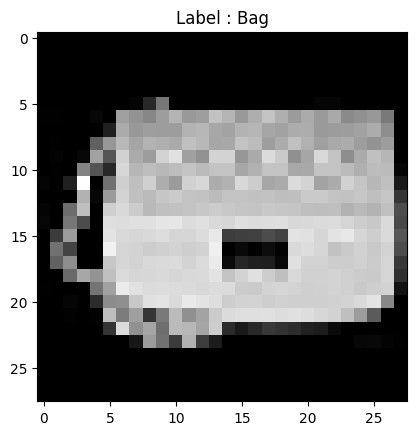

In [5]:
def show_random_image():
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    random_index = np.random.randint(0,len(images))
    random_image = images[random_index]
    label = labels[random_index].item()

    random_image = random_image.squeeze().numpy()

    plt.imshow(random_image, cmap = 'gray')
    plt.title(f"Label : {class_names[label]}")
    plt.show()

show_random_image()

In [20]:
class CNN(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, p = 0):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, out_1, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(out_1, out_2, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64,10)
        self.dropout = nn.Dropout(p = p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [30]:
epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accu = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accu)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accu:.2f}%")

Epoch 1/10, Loss: 0.1966, Accuracy: 92.83%
Epoch 2/10, Loss: 0.1657, Accuracy: 93.86%
Epoch 3/10, Loss: 0.1379, Accuracy: 94.85%
Epoch 4/10, Loss: 0.1192, Accuracy: 95.53%
Epoch 5/10, Loss: 0.0999, Accuracy: 96.29%
Epoch 6/10, Loss: 0.0847, Accuracy: 96.85%
Epoch 7/10, Loss: 0.0710, Accuracy: 97.36%
Epoch 8/10, Loss: 0.0605, Accuracy: 97.81%
Epoch 9/10, Loss: 0.0538, Accuracy: 98.03%
Epoch 10/10, Loss: 0.0468, Accuracy: 98.32%


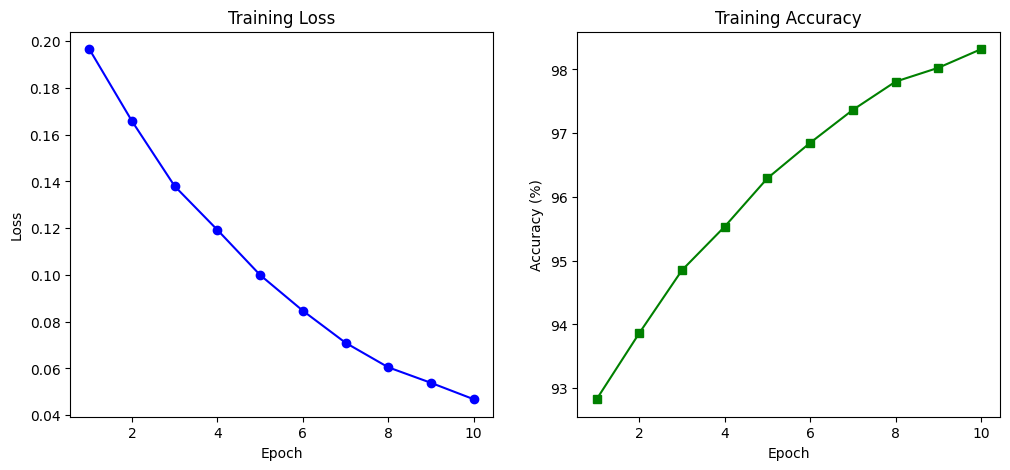

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='s', linestyle='-', color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")

plt.show()

In [32]:
correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 91.55%
